In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from fbprophet import Prophet
%matplotlib inline

In [2]:
data = pd.read_csv('./全部数据/附件1-区域15分钟负荷数据.csv', parse_dates=['数据时间'], index_col=[0])
data

,总有功功率（kw）
数据时间,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269
...,...
2021-08-31 22:45:00,202409.1270
2021-08-31 23:00:00,218576.4635
2021-08-31 23:15:00,200112.5091


In [3]:
# data中时间序列不连续，本来有128544行，但是data只有128156行
# 用重采样的方式将有断点的时间序列变成连续时间序列
data_fill = data.resample('15T').mean()
# 用中位数填充空缺值
data_fill[data_fill.isna().iloc[:,0]] = data.median()

In [4]:
data_fill

,总有功功率（kw）
数据时间,
2018-01-01 00:00:00,244033.7682
2018-01-01 00:15:00,232720.6402
2018-01-01 00:30:00,231685.6891
2018-01-01 00:45:00,227581.3317
2018-01-01 01:00:00,233482.4269
...,...
2021-08-31 22:45:00,202409.1270
2021-08-31 23:00:00,218576.4635
2021-08-31 23:15:00,200112.5091


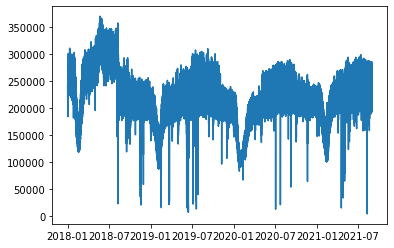

In [5]:
plt.plot(data_fill)

In [6]:
# 用原数据减去滑动平均数据的方法，求出波动图，再通过箱型图的方法将异常数据赋值为np.NaN
# prophet会根据插值的方法自动填充np.NaN值
def drop_outlier(data1, column, window=15):
    data_smooth = data1.iloc[:,column].rolling(window, center=True).mean()
    
    # 用滑动窗口给data_smooth数据两边各有window//2个的np.NaN值填充
    for i in range(window//2):
        sum=0
        for j in range(i+1):
            sum+=data1.iloc[j,column]
        data_smooth[i] = sum / (i+1)
    for i in range(window//2):
        sum=0
        for j in range(i+1):
            sum+=data1.iloc[len(data_smooth) - j - 1, column]
        data_smooth[len(data_smooth) - i - 1] = sum / (i+1)
    
    data_sub = data1.iloc[:,column] - data_smooth
    
    q1 = data_sub.quantile(0.25)
    q3 = data_sub.quantile(0.75)
    
    # 分别为箱线图的上界和下界
    upper_whisker = q3 + 1.5*(q3-q1)
    lower_whisker = q1 - 1.5*(q3-q1)

    rule = (lower_whisker > data_sub) | (upper_whisker < data_sub)
    
    data_drop_outlier = data1.copy()
    data_drop_outlier.loc[rule, data_drop_outlier.columns[column]] = np.NaN
    
    return data_drop_outlier

In [7]:
def FB(data1, column):
    df = pd.DataFrame({
        'ds': pd.Series(data1.iloc[:,column].index),
        'y': pd.Series(data1.iloc[:,column].values)
        })
    df['cap'] = data1.iloc[:,column].max()
    df['floor'] = data1.iloc[:,column].min()
    
    m = Prophet(
        changepoint_prior_scale=0.05, 
        daily_seasonality=False,
        yearly_seasonality=True, #年周期性
        weekly_seasonality=True, #周周期
        growth="linear",
        interval_width=0.8 #置信区间宽度，有多大概率落在浅蓝色线里

    )

    m.add_country_holidays(country_name='CN')#中国所有的节假日    

    m.fit(df)

    future = m.make_future_dataframe(periods=91, freq='D')
    future['cap'] = data1.iloc[:,column].max()
    future['floor'] = data1.iloc[:,column].min()

    forecast = m.predict(future)

    fig1 = m.plot(forecast)
    fig2 = m.plot_components(forecast)
    return future, forecast

In [8]:
data_max = data_fill.resample('D').max()
data_min = data_fill.resample('D').min()

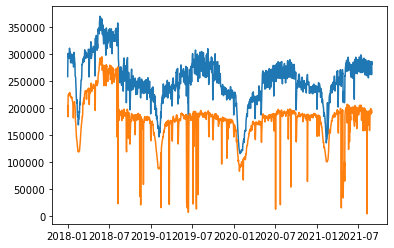

In [9]:
plt.plot(data_max)
plt.plot(data_min)

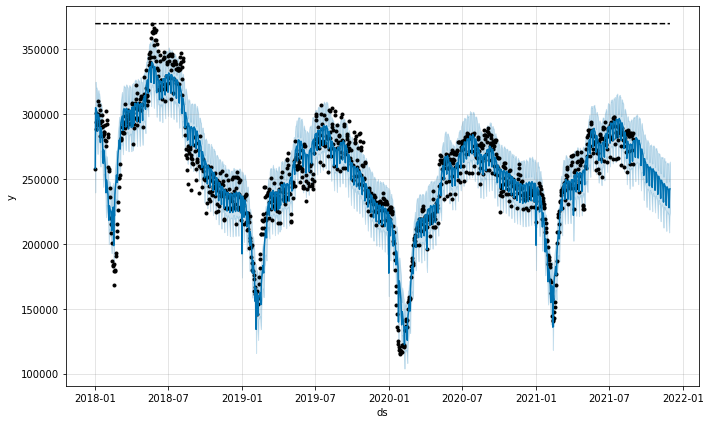

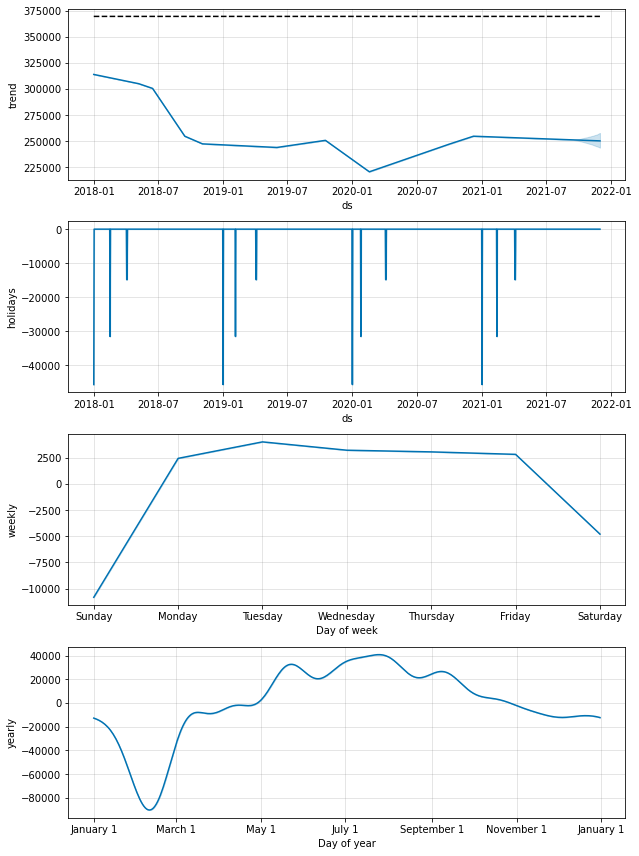

In [10]:
max_drop = drop_outlier(data_max, 0)
max_future, max_forecast = FB(max_drop, 0)

In [11]:
max_predict = pd.DataFrame(max_forecast.yhat.values[-91:], index=pd.date_range('2021-09', periods=91), columns=['总有功功率最大值（kw）'])
max_predict.index.name = '数据时间'

In [12]:
max_predict

,总有功功率最大值（kw）
数据时间,
2021-09-01,279105.639320
2021-09-02,279422.957792
2021-09-03,279626.403019
2021-09-04,272381.992206
2021-09-05,266653.238627
...,...
2021-11-26,241889.978195
2021-11-27,234038.040273
2021-11-28,227796.746714


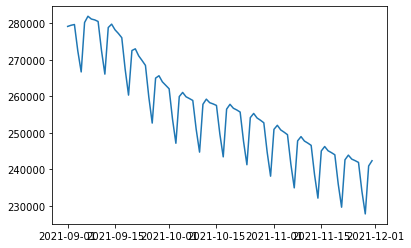

In [13]:
plt.plot(max_predict)

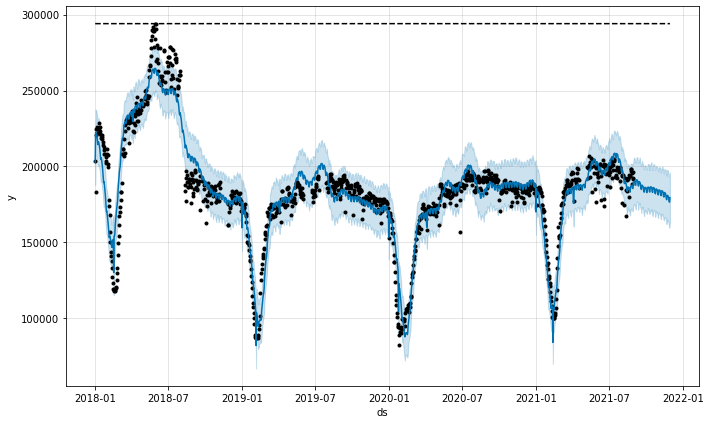

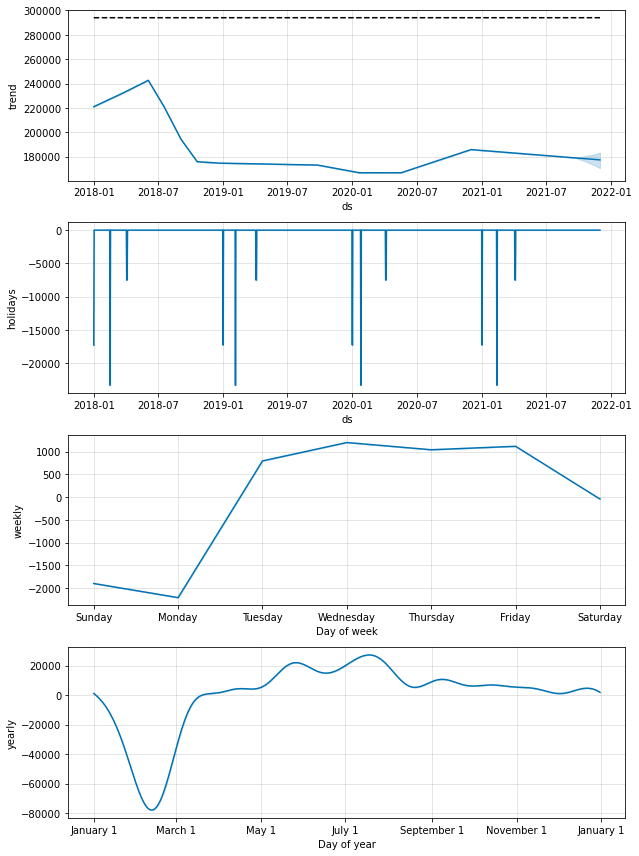

In [14]:
min_drop = drop_outlier(data_min, 0)
min_future, min_forecast = FB(min_drop, 0)

In [15]:
min_predict = pd.DataFrame(min_forecast.yhat.values[-91:], index=pd.date_range('2021-09', periods=91), columns=['总有功功率最小值（kw）'])
min_predict.index.name = '数据时间'

In [16]:
min_predict

,总有功功率最小值（kw）
数据时间,
2021-09-01,189766.117260
2021-09-02,189955.431785
2021-09-03,190340.950900
2021-09-04,189445.332814
2021-09-05,187801.539011
...,...
2021-11-26,180378.047930
2021-11-27,178999.710832
2021-11-28,176951.791850


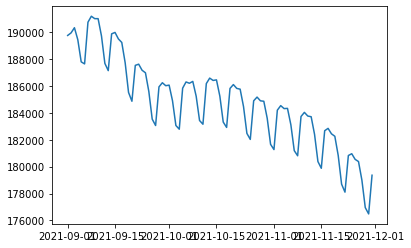

In [17]:
plt.plot(min_predict)

In [20]:
max_min_predict = pd.concat([max_predict, min_predict], axis=1)

In [21]:
max_min_predict

,总有功功率最大值（kw）,总有功功率最小值（kw）
数据时间,,
2021-09-01,279105.639320,189766.117260
2021-09-02,279422.957792,189955.431785
2021-09-03,279626.403019,190340.950900
2021-09-04,272381.992206,189445.332814
2021-09-05,266653.238627,187801.539011
...,...,...
2021-11-26,241889.978195,180378.047930
2021-11-27,234038.040273,178999.710832
2021-11-28,227796.746714,176951.791850


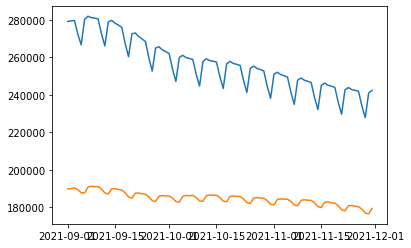

In [22]:
plt.plot(max_min_predict)

In [23]:
max_min_predict.to_csv('未来三个月日负荷最大值最小值预测.csv')

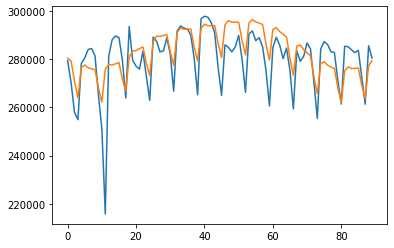

In [66]:
begin = 90
plt.plot(data_max.values[-begin:])
plt.plot(max_forecast.yhat.values[-91-begin:-91])

In [67]:
abs_max = [abs(data_max.values[-begin:][i][0]-max_forecast.yhat.values[-91-begin:-91][i]) for i in range(begin)]
sum_max = max_forecast.yhat.values[-91-begin:-91].sum()

In [69]:
# 最大值预测的MAE
sum(abs_max)/begin

7035.541068489795

In [71]:
# 最大值预测的MAPE
sum(abs_max)/sum_max

0.024907384760682265

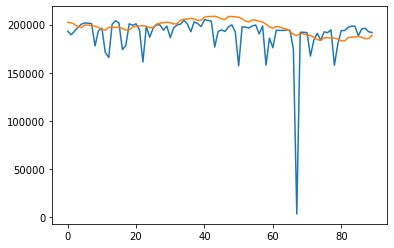

In [64]:
begin = 90
plt.plot(data_min.values[-begin:])
plt.plot(min_forecast.yhat.values[-91-begin:-91])

In [53]:
abs_min = [abs(data_min.values[-begin:][i][0]-min_forecast.yhat.values[-91-begin:-91][i]) for i in range(begin)]
sum_min = min_forecast.yhat.values[-91-begin:-91].sum()

In [61]:
# 最小值预测的MAE
sum(abs_min)/begin

10945.549544157073

In [62]:
# 最小值预测的MAPE
sum(abs_min)/sum_min

0.05546047635914719